# Data Cleaning 2: Missing Values

### Imports and getting set up

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

### DB Connection & Call data

In [2]:
confile = list(pd.read_csv('../../dbcon.csv'))
postgres_db = 'useducation'
db_connection = 'postgresql://{}:{}@{}:{}/{}'.format(confile[0], confile[1], confile[2], confile[3], postgres_db)

In [21]:
query = '''
SELECT *
FROM useducation
;'''

useducation = pd.read_sql(query, db_connection)
useducation.sort_values('PRIMARY_KEY').reset_index(drop=True).head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,1992_AMERICAN_SAMOA,AMERICAN_SAMOA,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,981.0,886.0,748.0,7969.0,3355.0,12786.0,NaN,NaN,NaN,NaN
3,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
4,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665


#### 1. Determine all the variable types and find the fraction of the missing values for each variable.

In [22]:
display(
    useducation.info(),
    useducation.isna().mean().sort_values(ascending=False)
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 25 columns):
PRIMARY_KEY                     1492 non-null object
STATE                           1492 non-null object
YEAR                            1492 non-null int64
ENROLL                          1229 non-null float64
TOTAL_REVENUE                   1280 non-null float64
FEDERAL_REVENUE                 1280 non-null float64
STATE_REVENUE                   1280 non-null float64
LOCAL_REVENUE                   1280 non-null float64
TOTAL_EXPENDITURE               1280 non-null float64
INSTRUCTION_EXPENDITURE         1280 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1280 non-null float64
OTHER_EXPENDITURE               1229 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1280 non-null float64
GRADES_PK_G                     1319 non-null float64
GRADES_KG_G                     1360 non-null float64
GRADES_4_G                      1361 non-null float64
GRADES_8_G                      1

None

AVG_READING_8_SCORE             0.666220
AVG_MATH_8_SCORE                0.643432
AVG_READING_4_SCORE             0.642761
AVG_MATH_4_SCORE                0.640751
OTHER_EXPENDITURE               0.176273
ENROLL                          0.176273
TOTAL_REVENUE                   0.142091
FEDERAL_REVENUE                 0.142091
STATE_REVENUE                   0.142091
LOCAL_REVENUE                   0.142091
TOTAL_EXPENDITURE               0.142091
INSTRUCTION_EXPENDITURE         0.142091
SUPPORT_SERVICES_EXPENDITURE    0.142091
CAPITAL_OUTLAY_EXPENDITURE      0.142091
GRADES_PK_G                     0.115952
GRADES_ALL_G                    0.115952
GRADES_KG_G                     0.088472
GRADES_4_G                      0.087802
GRADES_8_G                      0.087802
GRADES_12_G                     0.087802
GRADES_1_8_G                    0.087802
GRADES_9_12_G                   0.087802
YEAR                            0.000000
STATE                           0.000000
PRIMARY_KEY     

#### 2. Notice that the data has a time dimension (year). For this assignment, forget about time and treat all the observations as if they're from the same year. Choose a strategy to deal with the missing values for each variables. For which variables would filling in the missing values with some value make sense? For which might tossing out the records entirely make sense?

<span style='color:blue'>It would only make sense to fill in values for revenue and expenditure based on the states data for previous and/or following years.  The Grades and scores are the observations we're trying to make determinations from, so I would toss records of those nulls and only work with what was provided</span>

In [23]:
expcols = [column for column in useducation.columns if 'EXPENDITURE' in column]
revcols = [column for column in useducation.columns if 'REVENUE' in column]
fillcols = expcols + revcols

ed2df = useducation.copy()

for col in fillcols:
    ed2df.loc[:, col] = ed2df.loc[:, col].fillna(ed2df.loc[:, col].mean())

#### 3. Now, take into account the time factor. Replicate your second answer but this time fill in the missing values by using a statistic that is calculated within the year of the observation. For example, if you want to fill a missing value for a variable with the mean of that variable, calculate the mean by using only the observations for that specific year.

In [24]:
ed3df = useducation.copy()

for col in fillcols:
    for year in ed3df['YEAR'].unique():
        ed3df.loc[ed3df['YEAR'] == year, col] = ed3df.loc[
            ed3df['YEAR'] == year, col
        ].fillna(
            ed3df[ed3df['YEAR'] == year][col].mean()
        )

#### 4. This time, fill in the missing values using interpolation (extrapolation).

In [25]:
ed4df = useducation.copy()

for col in fillcols:
    ed4df.loc[:, col] = ed4df.loc[:, col].interpolate()

#### 5. Compare your results for the 2nd, 3rd, and 4th questions. Do you find any meaningful differences?

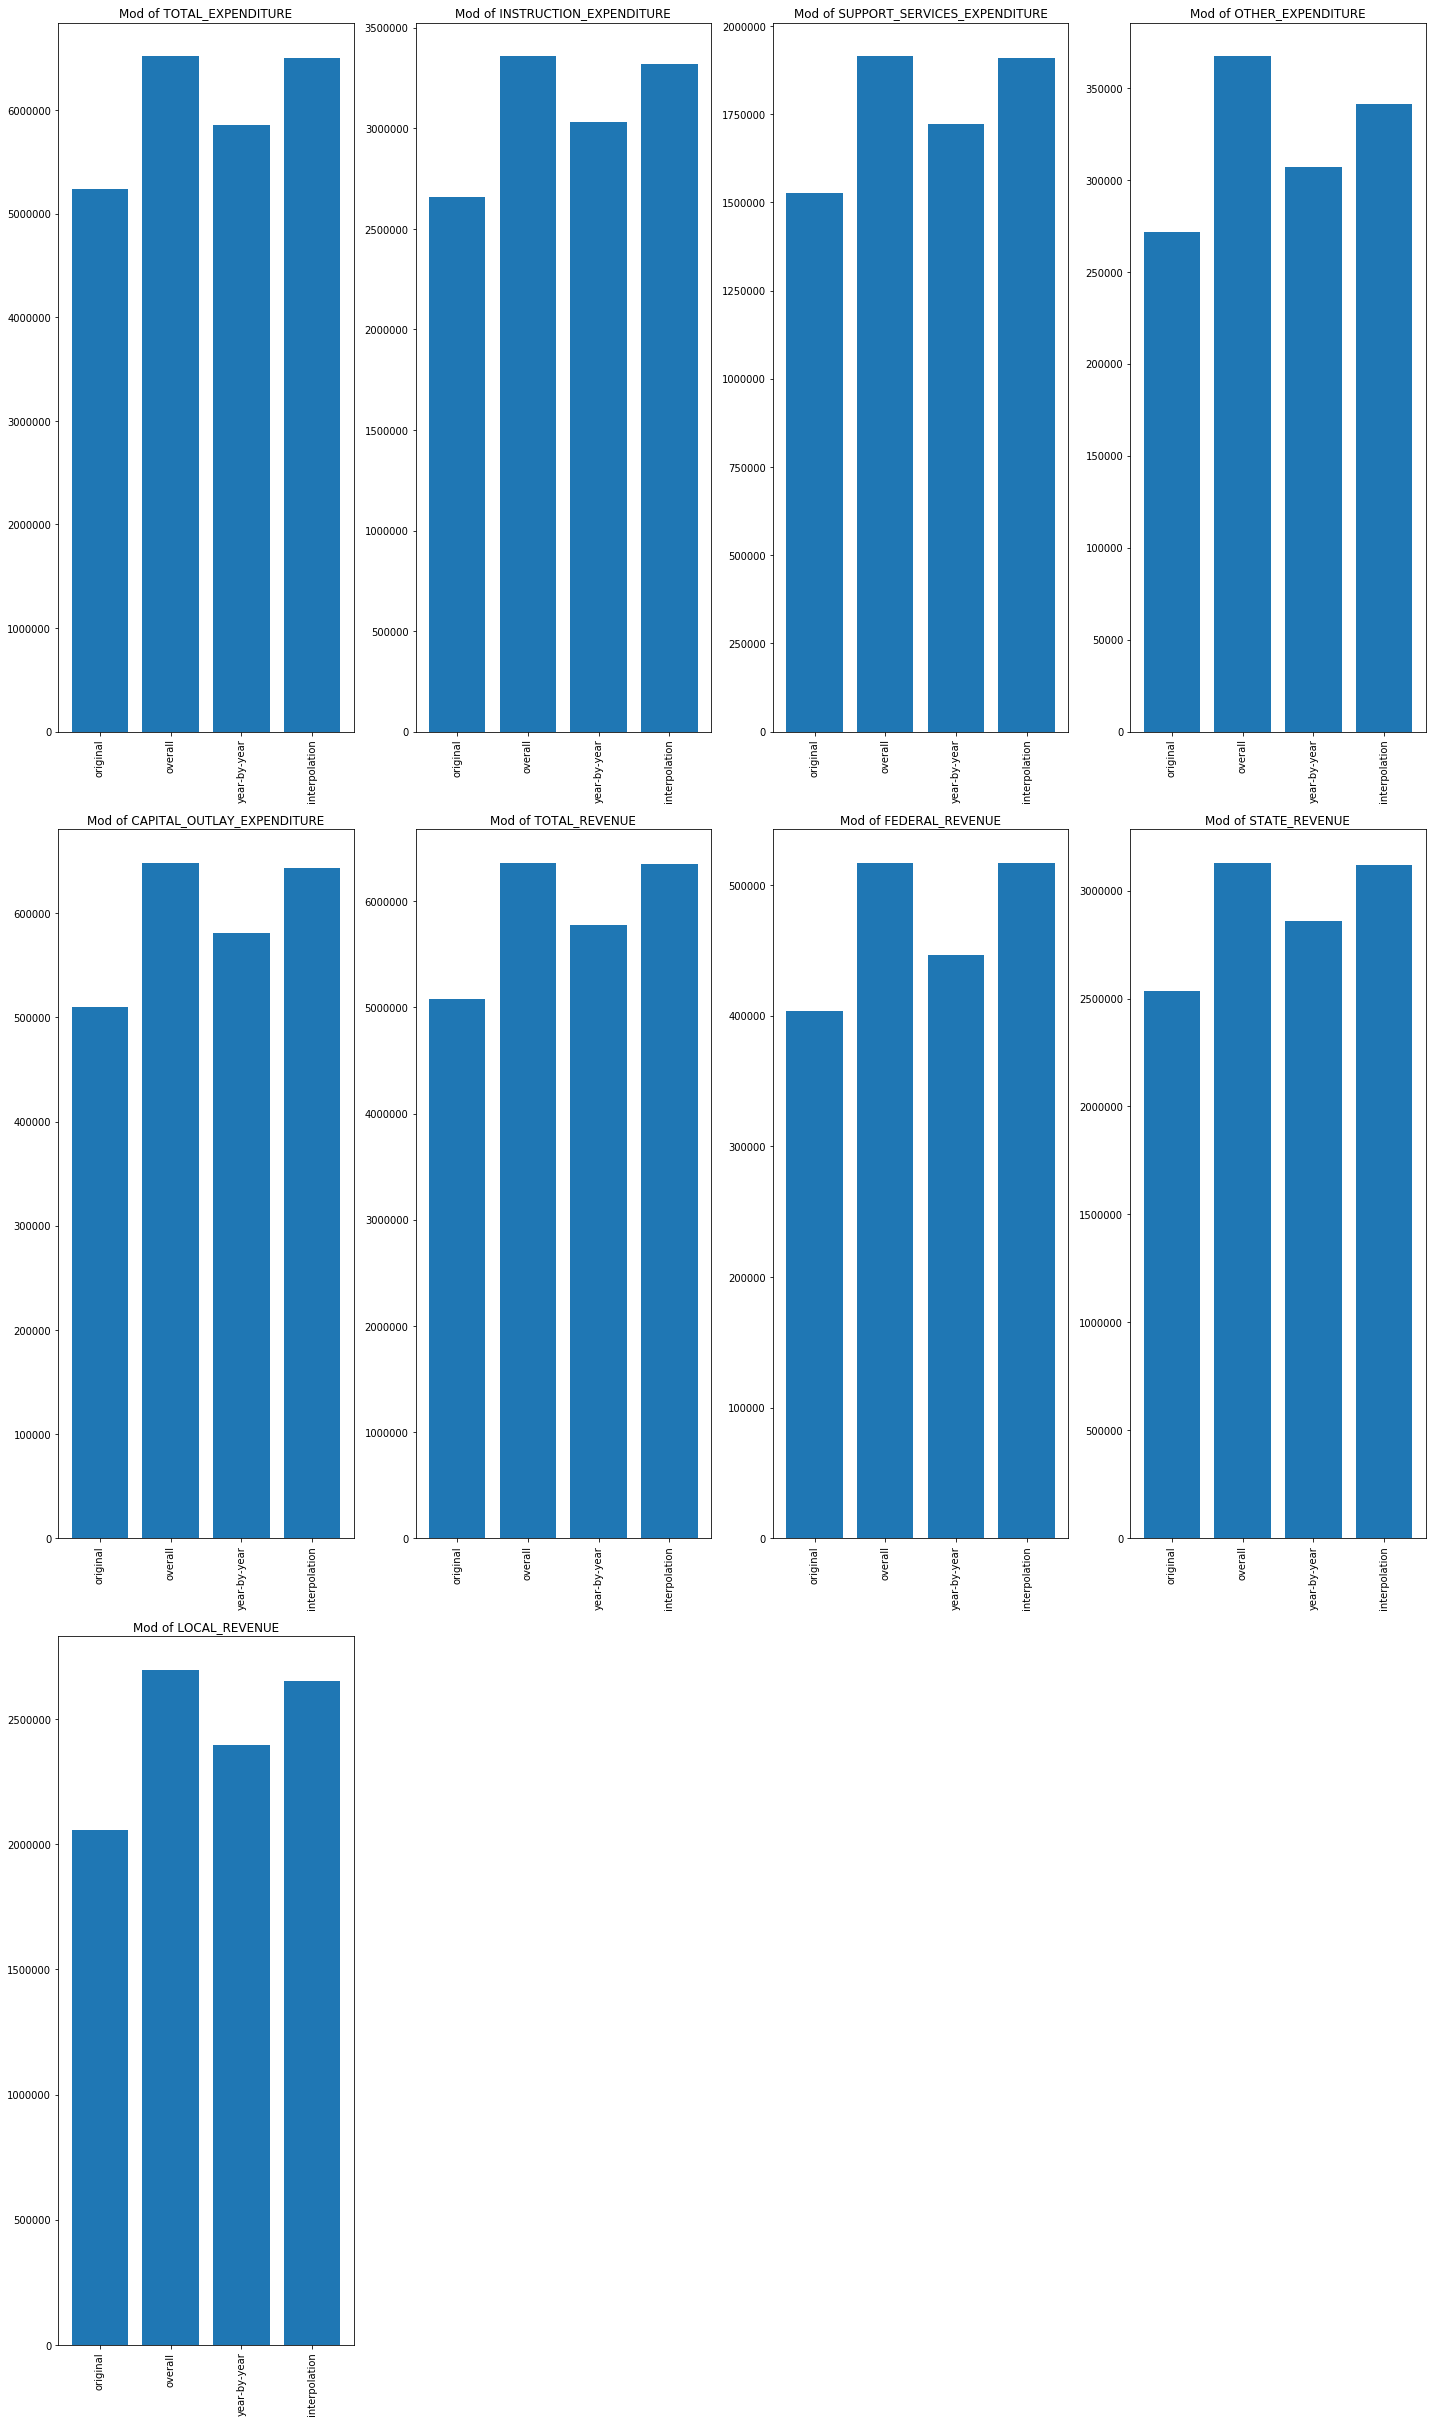

In [26]:
fig = plt.figure(figsize=(20,100))

for i, col in enumerate(fillcols):
    df = pd.concat(
        [useducation[col], ed2df[col], ed3df[col], ed4df[col]], 
        axis=1
    )
    plt.subplot(len(fillcols), 4, i+1)
    plt.bar(["original", "overall", "year-by-year", "interpolation"], df.median())
    plt.xticks(rotation='vertical')
    plt.title("Mod of {}".format(col))
    
plt.tight_layout()
plt.show()
